# MNIST

Follow this instruction:

https://www.analyticsvidhya.com/blog/2020/07/how-to-train-an-image-classification-model-in-pytorch-and-tensorflow/

In [1]:
# importing the libraries
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
# version of pytorch
print(torch.__version__)

1.9.0


In [3]:
# transformations to be applied on images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [5]:
# defining the training and testing set
trainset = datasets.MNIST('data/MNIST', download=True, train=True, transform=transform)
testset = datasets.MNIST('data/MNIST', download=True, train=False, transform=transform)

In [6]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/MNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [7]:
# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [8]:
# shape of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


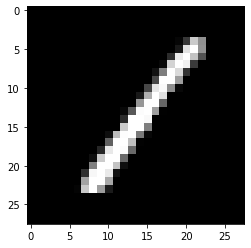

In [10]:
# visualizing the training images
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

In [11]:
# shape of validation data
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Defining Model Architecture


In [23]:
# defining the model architecture
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            #nn.Linear(4 * 7 * 7, 10)
            nn.Linear(4 * 7 * 7, 10)
      )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

Parameters

- in_channels (int) – Number of channels in the input image
- out_channels (int) – Number of channels produced by the convolution
- kernel_size (int or tuple) – Size of the convolving kernel
- stride (int or tuple, optional) – Stride of the convolution. (Default: 1)
- padding (int or tuple, optional) – Zero-padding added to both sides of the input (Default: 0)
- padding_mode (string, optional) – zeros
- dilation (int or tuple, optional) – Spacing between kernel elements. (Default: 1)
- groups (int, optional) – Number of blocked connections from input to output channels. (Default: 1)
- bias (bool, optional) – If True, adds a learnable bias to the output. (Default: True)

BATCHNORM2D

https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html


In [24]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [25]:
%%time

for i in range(10):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 0.19644056740743138
Epoch 2 - Training loss: 0.09758875793469612
Epoch 3 - Training loss: 0.08145711934471976
Epoch 4 - Training loss: 0.07470306229399347
Epoch 5 - Training loss: 0.07033862798439482
Epoch 6 - Training loss: 0.06700670578256884
Epoch 7 - Training loss: 0.06531948315799792
Epoch 8 - Training loss: 0.06322327051855334
Epoch 9 - Training loss: 0.06149278321863909
Epoch 10 - Training loss: 0.057959989830504044
CPU times: user 3min 2s, sys: 15.4 s, total: 3min 17s
Wall time: 2min 34s


In [26]:
# getting predictions on test set and measuring the performance
correct_count, all_count = 0, 0

for images,labels in testloader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1, 1, 28, 28)
        with torch.no_grad():
            logps = model(img)

    
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9733
